In [1]:
from tectosaur2.nb_config import setup
setup()

In [2]:
import warnings
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from tectosaur2 import (
    integrate_term,
    pts_grid,
    gauss_rule,
    upsample,
    panelize_symbolic_surface,
    refine_surfaces,
)
from tectosaur2.laplace2d import DoubleLayer, Hypersingular


In [82]:
sp_t = sp.var('t')
x, y = sp_t, 0.3 * sp.sin((sp_t + 1) * 2 * sp.pi)
surface = (sp_t, x, y)
# kernel = DoubleLayer(d_cutoff=4.0, d_up=2.0, d_qbx=0.4, default_tol=1e-13, max_p=100)
kernel = Hypersingular(d_cutoff=5.0, d_up=2.5, d_qbx=0.5, default_tol=1e-12, max_p=300)

In [83]:
def slip_fnc(xhat):
    # This must be zero at the endpoints for potential gradient to be finite.
    # return np.ones_like(xhat)
    return np.cos(xhat * np.pi) + 1.0

surface_low = refine_surfaces([surface], gauss_rule(6), max_curvature=1.5)
# surface_low = panelize_symbolic_surface(*surface, gauss_rule(10), n_panels=30)
slip_low = slip_fnc(surface_low.quad_pts)
surface_low.n_panels

32

In [89]:

nobs = 200
zoomx = [-1.5, 1.5]
zoomy = [-1.5, 1.5]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obs_pts = pts_grid(xs, ys)

singularities = np.array(
    [
        [surface[1].subs(surface[0], -1), surface[2].subs(surface[0], -1)],
        [surface[1].subs(surface[0], 1), surface[2].subs(surface[0], 1)],
    ]
)
qbx_mat, report = integrate_term(
        kernel, obs_pts, surface_low, tol=1e-8, singularities=singularities, return_report=True
    )
qbx_vals = qbx_mat[:, 1, :, 0].dot(slip_low).reshape((nobs, nobs))


/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:210: UserWarning: Some expanded integrals reached maximum expansion order. These integrals may be inaccurate.
  warnings.warn(


In [90]:
report['p'][report['p']>=50]

array([ 54,  64,  54,  64,  64,  64,  64,  54,  54, 300, 300, 194,  54,
       144,  64,  84,  94,  54,  74,  54, 224, 184,  94,  94, 104,  54,
        74,  54,  74, 244,  54,  54, 174,  94,  64,  64,  54,  54, 104,
        74,  74, 124,  64,  54,  54,  84, 284, 284,  84,  54,  54,  64,
       124,  74,  74, 104,  54,  54,  64,  64,  94, 174,  54,  54, 244,
        74,  54,  74,  54, 104,  94,  94, 184, 224,  54,  74,  54,  94,
        84,  64, 144,  54, 194, 300, 300,  54,  54,  64,  64,  64,  64,
        54,  64,  54], dtype=int32)

In [91]:
report['exp_rs'][report['p']>=50]

array([0.03383182, 0.03383182, 0.03383182, 0.03383182, 0.03383182,
       0.03383182, 0.03383182, 0.03383182, 0.0452643 , 0.03383182,
       0.03383182, 0.0452643 , 0.03383182, 0.03383182, 0.0452643 ,
       0.0452643 , 0.0452643 , 0.0452643 , 0.0452643 , 0.0452643 ,
       0.0452643 , 0.0452643 , 0.0452643 , 0.0452643 , 0.05786859,
       0.05786859, 0.05786859, 0.05786859, 0.05786859, 0.05786859,
       0.05786859, 0.05786859, 0.05786859, 0.05786859, 0.05786859,
       0.06536074, 0.05786859, 0.06536074, 0.06536074, 0.03921644,
       0.06536074, 0.06536074, 0.06536074, 0.06536074, 0.06536074,
       0.06536074, 0.06536074, 0.06536074, 0.06536074, 0.06536074,
       0.06536074, 0.06536074, 0.06536074, 0.06536074, 0.03921644,
       0.06536074, 0.06536074, 0.05786859, 0.06536074, 0.05786859,
       0.05786859, 0.05786859, 0.05786859, 0.05786859, 0.05786859,
       0.05786859, 0.05786859, 0.05786859, 0.05786859, 0.05786859,
       0.0452643 , 0.0452643 , 0.0452643 , 0.0452643 , 0.04526

In [92]:
report.keys()

dict_keys(['combined_src', 'srcs', 'obs_pts', 'n_qbx', 'p', 'integration_failed', 'n_subsets', 'max_order_reached', 'use_qbx', 'exp_centers', 'exp_rs', 'closest_src_pts', 'direction', 'on_surface', 'n_nearfield'])

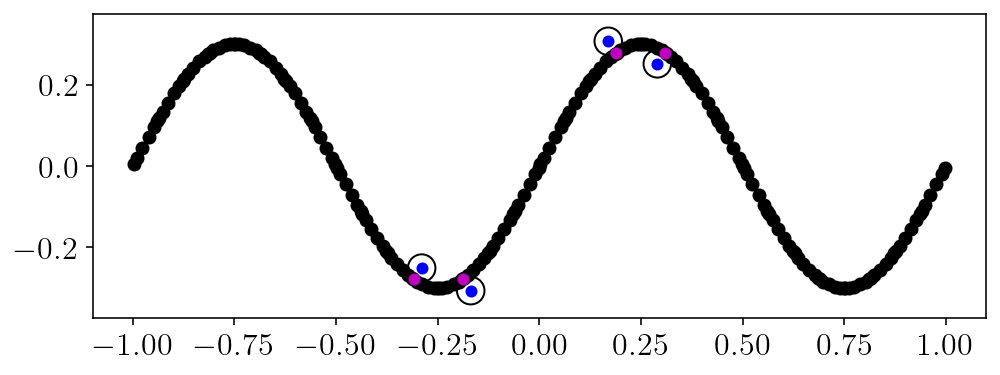

In [93]:
from tectosaur2.debug import plot_max_order_reached
plt.figure(figsize=(8,8))
plot_max_order_reached(report)
# plt.xlim([-1, -0.3])
# plt.ylim([0.5, 1.3])
plt.show()

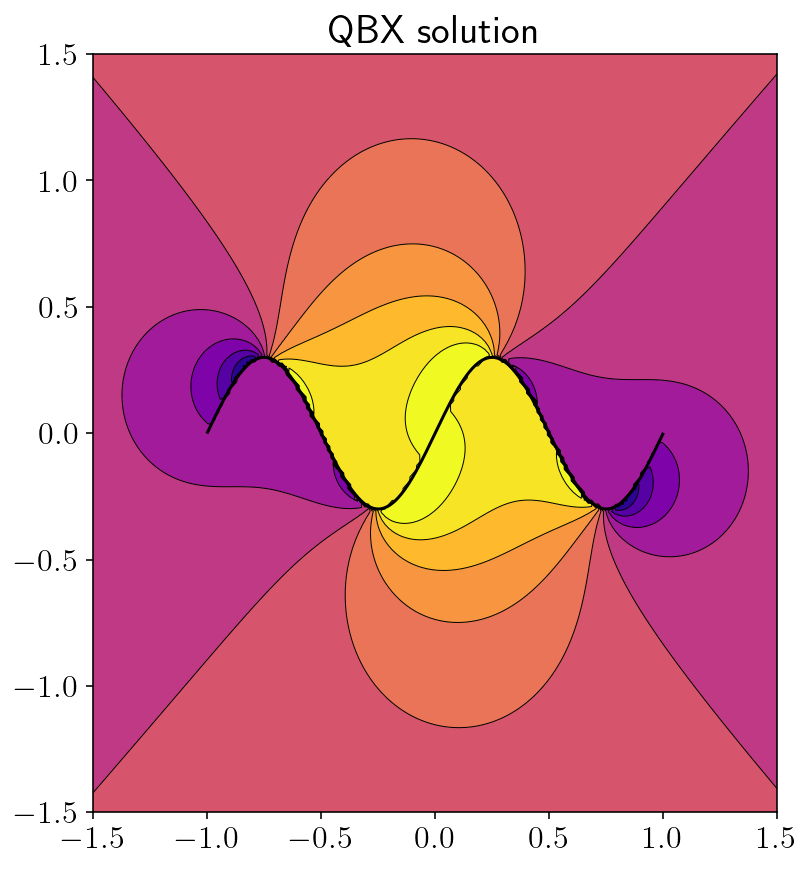

In [94]:

vmin = -1.0
vmax = 1.0
levels = np.linspace(vmin, vmax, 11)

obsx = obs_pts[:, 0].reshape((nobs, nobs))
obsy = obs_pts[:, 1].reshape((nobs, nobs))

plt.figure(figsize=(16, 12))
plt.subplot(2, 3, 4)
plt.title("QBX solution")
cntf = plt.contourf(obsx, obsy, qbx_vals, levels=levels, extend="both")
plt.contour(
    obsx,
    obsy,
    qbx_vals,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.plot(surface_low.pts[:, 0], surface_low.pts[:, 1], "k-", linewidth=1.5)
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.tight_layout()
plt.show()
